In [1]:
import sys
sys.path.append('..')
import config
from autoencoding import AutoEncoder

Using Theano backend.


In [2]:
import os
model_path = config.MODEL_PATH
model = AutoEncoder.from_h5(model_path)

../autoencoding.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/dense_1_i..., outputs=sigmoid.0)`
  output=model.layers[idx_code_layer].output)


In [3]:
train_dir = config.TRAIN_DIR
files = [os.path.join(train_dir, f) for f in os.listdir(train_dir)][:15000]

# Look at how well autoencoder predicts input

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_test_input(files, k=5):
    files = random.sample(files, k=k)
    return files, [np.load(f) * 2000 for f in files]

def compare_predictions(test_input, model, labels):
    plt.figure(figsize=(30, 30))
    f, axarr = plt.subplots(len(test_input), sharex=True, sharey=True)
    f.subplots_adjust(hspace=.5)
    for i, (X, L) in enumerate(zip(test_input, labels)):
        xshape = X.shape[0]
        y_hat = model.predict(X.reshape(1, xshape))
        axarr[i].plot(X)
        axarr[i].plot(y_hat.reshape((xshape,)), color='r')
        axarr[i].set_title(L, fontsize=8)

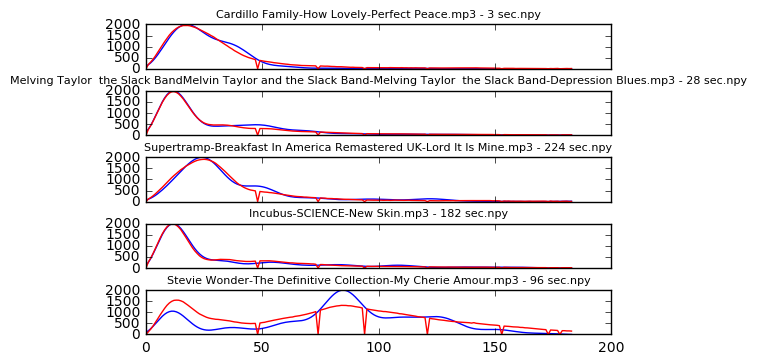

In [5]:
test_files, test_input = get_test_input(files)
compare_predictions(test_input, model, [os.path.basename(f) for f in test_files])

# Evaluate search

In [25]:
def init_db(encoder, files, feature_size):
    items = np.zeros((len(files), feature_size))
    for i, f in enumerate(files):
        X = np.load(f) * 2000
        X = X.reshape((1, X.shape[0])) 
        items[i, :] = X
    codes = encoder(items)
    db = [(f, code) for f, code in zip(files, codes)]
    return db

def linear_search(db, q, score_func):
    scores = [(k, score_func(q, v)) for k, v in db]
    return sorted(scores, key=lambda x: x[1], reverse=True)

def cosine_distance(x1, x2):
    return x1.dot(x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

In [26]:
%%time
db = init_db(model.encode, files, 184)

CPU times: user 17.3 s, sys: 6.08 s, total: 23.3 s
Wall time: 17 s


In [27]:
test = random.choice(files)
test

'../data/preprocessed/August Burns Red-Thrill Seeker-Too Late For Roses.mp3 - 83 sec.npy'

In [28]:
q = np.load(test) * 2000
q = model.encode(q.reshape((1, q.shape[0]))).transpose().reshape((32,))
print(q.shape)
q

(32,)


array([ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.], dtype=float32)

In [29]:
%%time
linear_search(db, q, cosine_distance)

CPU times: user 492 ms, sys: 12 ms, total: 504 ms
Wall time: 629 ms


[('../data/preprocessed/Pearl Jam-Backspacer-Johnny Guitar.mp3 - 139 sec.npy',
  1.0000001),
 ('../data/preprocessed/Norma Jean-The AntiMother-And There Will Be a Swarm of Hornets.mp3 - 74 sec.npy',
  1.0000001),
 ('../data/preprocessed/Ozzy Osbourne-The Ozzman Cometh Greatest Hits Reissue-Back on Earth.mp3 - 123 sec.npy',
  1.0000001),
 ('../data/preprocessed/Billy Idol-Greatest Hits-Mony Mony.mp3 - 82 sec.npy',
  1.0000001),
 ('../data/preprocessed/KC  The Sunshine Band-KC And The Sunshine Band 25th Anniversary Collection Disc 2-Please Dont Go.mp3 - 129 sec.npy',
  1.0000001),
 ('../data/preprocessed/Bush-The Science Of Things-English Fire.mp3 - 157 sec.npy',
  1.0000001),
 ('../data/preprocessed/Van Morrison-Moondance-Caravan.mp3 - 88 sec.npy',
  1.0000001),
 ('../data/preprocessed/Beastie Boys-Ill Communication-Eugenes Lament.mp3 - 74 sec.npy',
  1.0000001),
 ('../data/preprocessed/Franz Ferdinand-Franz Ferdinand-Take Me Out.mp3 - 123 sec.npy',
  1.0000001),
 ('../data/preprocessed

# Look at distribution of codes. Are they binary?

In [30]:
db[:100]

[('../data/preprocessed/Wall of Voodoo-Call of the West-They Dont Want Me.mp3 - 119 sec.npy',
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
          0.,  0.,  0.,  0.,  1.,  1.], dtype=float32)),
 ('../data/preprocessed/King Crimson-In The Court Of The Crimson King-Moon Child.mp3 - 99 sec.npy',
  array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,
          0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.], dtype=float32)),
 ('../data/preprocessed/A Tribe Called Quest-Midnight Marauders-Hot Sex.mp3 - 48 sec.npy',
  array([  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   9.07811900e-24,
           0.00000000e+00,   0.00000000e+00,   0.0000

In [33]:
from collections import Counter
from itertools import chain

In [41]:
c = Counter([round(c, 2) for file, code in db for c in code])

(array([  3.28995000e+05,   3.20000000e+01,   1.40000000e+01,
          1.10000000e+01,   2.80000000e+01,   1.10000000e+01,
          2.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+01,
          1.80000000e+01,   1.00000000e+01,   9.00000000e+00,
          1.10000000e+01,   4.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+01,
          1.00000000e+01,   1.00000000e+00,   1.00000000e+00,
          1.90000000e+01,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+01,   1.40000000e+01,   1.50770000e+05]),
 array([ 0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ,  0.53333333,  0.56666667,  0.6       ,  0.63333333,
         0.66666667,  0.7       ,  0.73333333,  0.76666667,  0.8       ,
         0.83

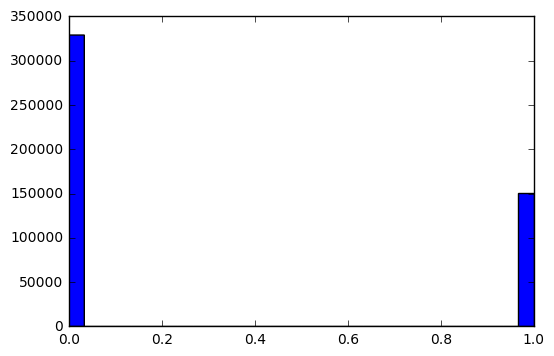

In [47]:
plt.hist([round(c, 2) for _, code in db for c in code], bins=30)

# Semantic hashing

In [55]:
y = np.array([[2**i for i in range(32)]])
y.shape

(1, 32)

In [59]:
X = np.array([c for _, c in db])
X.shape

(15000, 32)

In [75]:
keys = X.dot(y.transpose())

In [65]:
Counter(kk for k  in keys for kk in k).most_common()

[(3229876290.0, 979),
 (3246656066.0, 835),
 (3246655554.0, 541),
 (1103137540.0, 484),
 (1099172612.0, 434),
 (3229876802.0, 399),
 (3246656326.0, 359),
 (3246656256.0, 336),
 (1103141636.0, 248),
 (1099209476.0, 226),
 (3313764352.0, 220),
 (3246656000.0, 214),
 (3246656320.0, 205),
 (1099176708.0, 198),
 (3229877058.0, 193),
 (3246660352.0, 178),
 (3246656260.0, 174),
 (1105304324.0, 160),
 (3313764864.0, 156),
 (1103207172.0, 151),
 (3229878338.0, 148),
 (1367645060.0, 136),
 (1099172676.0, 129),
 (1099209604.0, 125),
 (3246656064.0, 123),
 (1371839364.0, 120),
 (3246656322.0, 120),
 (3313768960.0, 109),
 (1105238788.0, 108),
 (1103403780.0, 104),
 (1103104836.0, 102),
 (3313768448.0, 98),
 (3296987136.0, 95),
 (1103104772.0, 90),
 (1906112694.0, 84),
 (1099176836.0, 79),
 (1103104838.0, 78),
 (3246656070.0, 75),
 (3246656324.0, 73),
 (1099172678.0, 73),
 (3583776896.0, 73),
 (3246655488.0, 70),
 (3246660096.0, 68),
 (3582204416.0, 68),
 (1103403908.0, 68),
 (1103366982.0, 63),
 (3

In [ ]:
class SemanticHashTable:
    def __init__(self, keys, values, encoder):
        self._vint = np.array([2**i for i in range(encoder.code_length)])
        keys = self._int(keys)
        self._kvps = collections.defaultdict()
        for k, v in zip(keys, values):
            self._kvps[k].append(v)

    def _int(self, keys):
        X = np.array(keys)
        return X.dot(self._vint.transpose())

    def query(self, q):
        key = encoder.encode(q).dot(self._vint.transpose())[0]

    @staticmethod
    def _find_matches(key):
        pass
        

In [74]:
model._encoder.output_shape

(None, 32)